<a href="https://colab.research.google.com/github/marcosvnespolo/Portifolio/blob/main/Detec%C3%A7%C3%A3o_de_Fraudes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objetivo
Criar uma máquina preditiva que que identifique o comportamento de transações possivelmente fraudulentas.
O Dataset utilizado foi extraído do site kaggle e pode ser encontrado no link:
https://drive.google.com/file/d/1vXmPXvOjGatcGS_RwcF-h-AGXf9iFZkX/view?usp=sharing

## Importando as bibliotecas necessárias

In [44]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## Importando nossos dados


In [45]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/Fraude Hotmart/fraud.csv')
display(data)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int64  
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         object 
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
!pip install dataprep

Relatório automatizado

DataPrep Report
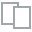
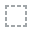
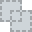
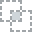
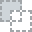
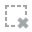
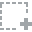
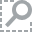
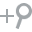
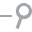
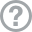
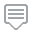
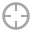
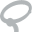
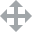
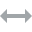
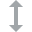
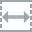
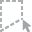
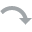
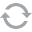
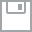
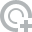
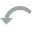
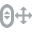
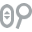
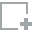
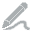
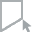
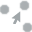
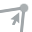
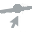

In [9]:
from dataprep.eda import create_report
create_report(data)

## Avaliando o tipo de transação

In [11]:
display(data.type.value_counts())

1    2237500
2    2151495
3    1399284
4     532909
5      41432
Name: type, dtype: int64

Através de um gráfico de rosca, podemos visualizar de forma mais eficiente os tipos de transação realizados

In [12]:
type = data['type'].value_counts()
transactions = type.index
quantity = type.values

import plotly.express as px
figure = px.pie(data,
                values = quantity,
                names = transactions, hole=0.5,
                title = 'Distribuição dos tipos de transação')
figure.show()

Também podemos checar a correlação do nosso target com as demais variáveis

In [17]:
correlation = data.corr()
print(correlation['isFraud'].sort_values(ascending=False))

isFraud           1.000000
amount            0.076688
isFlaggedFraud    0.044109
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64


Observa-se que o conjunto de dados já se encontra muito bem estruturado, sem valores ausentes, desta forma não se faz necessária a limpeza dos dados, desta forma, podemos prosseguir para a construção do modelo ed ML.

In [18]:
# Convertendo todos os dados que forem da classe object para números
data['type'] = data['type'].map({'CASH_OUT': 1,
                                'PAYMENT': 2,
                                'CASH_IN':3,
                                'TRANSFER': 4,
                                 'DEBIT': 5})

In [19]:
# melhorando a vizualização
data['isFraud'] = data['isFraud'].map({0: 'No Fraud', 1: 'Fraud'})
display(data.head())

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,2,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,No Fraud,0
1,1,2,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,No Fraud,0
2,1,4,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,Fraud,0
3,1,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,Fraud,0
4,1,2,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,No Fraud,0


Podemos utilizar também a estatística descritiva para obter mais informações sobre o conjunto de dados.


In [24]:
# Obs: o parâmetro '.T' significa transposição, ou sejo, as linhas se transformam em colunas.
# O parâmetro foi aplicado apenas para melhorar a visualizalção.
data.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
type,6362620.0,2.055307e+00,9.808966e-01,1.0,1.00,2.000,3.000000e+00,5.000000e+00
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


In [25]:
# Avaliando o Target
data.isFraud.value_counts()

No Fraud    6354407
Fraud          8213
Name: isFraud, dtype: int64

## Separando variáveis explicativas (x) e variável target (y)

In [31]:
from sklearn.model_selection import train_test_split
x = np.array(data[['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig']])
y = np.array(data['isFraud'])

## Construindo a máquina preditiva

In [32]:
from sklearn.tree import DecisionTreeClassifier
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.10, random_state=42)
model = DecisionTreeClassifier()
model.fit(xtrain, ytrain)

DecisionTreeClassifier()

In [33]:
y_pred = model.predict(xtest)
y_pred

array(['No Fraud', 'No Fraud', 'No Fraud', ..., 'No Fraud', 'No Fraud',
       'No Fraud'], dtype=object)

## Avaliando a máquina preditiva

In [40]:
print('Métricas do Classification Report: \n', classification_report(ytest, y_pred))
print('Acurácia: \n', accuracy_score(ytest, y_pred))
print('Confusion Matrix: \n', confusion_matrix(ytest, y_pred))

Métricas do Classification Report: 
               precision    recall  f1-score   support

       Fraud       0.91      0.89      0.90       817
    No Fraud       1.00      1.00      1.00    635445

    accuracy                           1.00    636262
   macro avg       0.95      0.94      0.95    636262
weighted avg       1.00      1.00      1.00    636262

Acurácia: 
 0.9997406728674666
Confusion Matrix: 
 [[   726     91]
 [    74 635371]]


## Realizando novas predições

## Caso 1

In [42]:
# features = [type, amount, oldbalanceOrg, newbalanceOrig]
features = np.array([[4, 9000.60, 9000.60, 0.0]])
print(model.predict(features))

['Fraud']


## Caso 2

In [43]:
# features = [type, amount, oldbalanceOrg, newbalanceOrig]
features = np.array([[2, 5000, 2000, 3000]])
print(model.predict(features))

['No Fraud']


## Conclusões

*   Pbserva-se que a acurácia do modelo é bastante elevada, o que indica uma boa confiabilidade;
*   Além disso, testando para valores aleatórios o modelo também demonstrou comportamento satisfatório, sendo assim interessante para a prevensão de fraudes.


